# Tutorial 1: Gaussian Process Regression in pure python
### (with solutions to exercises)

This tutorial teaches how to do Gaussian process (GP) regression without using sophisticated packages. We recommend using gpytorch and/or BoTorch to do GP regression in practice, but this tutorial aims to show you how it works and to show that it isn't that hard to write code doing GP regression from scratch.

In [11]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os.path

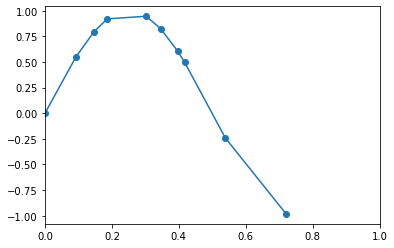

In [12]:
# Read in data from a file. Download this file before running the notebook.  
# If you forget to do this, the cell will generate the data for you, but small
# differences in random number generators might lead to different training data,
# which may make the graphs change.
filename = 'lab1_data.csv'

# If data doesn't exist, generate it
if ~os.path.exists(filename):
    np.random.seed(1)
    train_x = np.sort(np.random.rand(10)) # 10 points, uniformly distributed between 0 and 1
    train_y = [math.sin(x * (2 * math.pi)) + 0.0 * np.random.randn() for x in train_x]
    data = np.transpose([train_x,train_y])
    np.savetxt(filename,data)

# Read in data from a file.  
data = np.loadtxt(filename)
train_x = data[:,0] # First column of the data
train_y = data[:,1] # Second column of the data
plt.xlim(0,1)
plt.plot(train_x, train_y,'o-')

In [13]:
# This cell define a mean function and a kernel to use in GP regression

# This defines a mean function that evaluates to 0 for all inputs.
# lambda is a python keyword for defining functions on the fly.
mean0 = lambda x : 0.0

from scipy.special import kv, gamma
def matern(x1,x2,alpha0=1.0,length_scales=1.0,nu=1.5):
    # Simple implementation of the Matern kernel, with optional additional iid noise
    
    # Requires x1 and x2 to each represent a single point in the input domain of the 
    # function being modeled by GP regression. A single point can either be a 
    # scalar (int, float) if the function being modeled is 1-dimensional or 
    # a numpy array if it is multi-dimensional.
    # x1 and x2 must be of the same size, either both scalars,
    # or both numpy arrays of the same size.
    
    # r is the Euclidean distance between x1 and x2,
    # after we normalize each dimension by the length scale
    r = np.linalg.norm((x1-x2) / length_scales) 
    
    # When r is 0 (which casuse tmp to be 0),
    # the code below returns nan because tmp**nu is 0 but kv(nu,tmp) is infinite.
    # We fix this by adding a small amount to r in this situation.
    # We could have also fixed this by simply returning alpha0,
    # which is the correct covariance when r/0.
    if r==0.:
        r += np.finfo(float).eps
    
    tmp = np.sqrt(2*nu)*r
    c = 2**(1-nu) / gamma(nu)
    return alpha0 * c * tmp**nu * kv(nu, tmp)

#### Exercise 1

Write a function that calculates the mean and variance of the 
posterior distribution at a point test_x.  Use equation 3 on page 4 in the 
BayesOpt tutorial, https://arxiv.org/pdf/1807.02811.pdf. Your function should 
return the result as a list, where the first entry  is the posterior mean
and the second is the posterior variance.  You may find that because of 
numerical imprecision, the posterior variance can be slightly negative.

You may find it useful to use these two linear algebra functions from numpy for inverting matrices and doing matrix multiplication:
- numpy.linalg.inv: https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html
- numpy.matmul: https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

#### Hints for Exercise 1

*Hint 1*: The formula in the BayesOpt tutorial has the expression,
$$\Sigma_0(x_{1:n},x)$$ 
which is a short way of writing the column vector,
$$[\Sigma_0(x_1,x), \ldots, \Sigma_0(x_n,x)]^T$$.

Suppose we have python code where:
* $\Sigma_0$ is computed by the function `kernel`
* $x_{1:n}$ is stored in the list `train_x`
* We have another point `x`

So then the row vector $\Sigma_0(x_{1:n},x)$ we want to construct is:

    [kernel(train_x[0],x),..., kernel(train_x[n-1],x))]

A quick way to construct this row vector as a list is 

    [kernel(y,x) for y in train_x]

In [14]:
# Hint 1: An example illustrating the statements above
_train_x = [0.5, 1.1]
x = 0.2
kernel = matern
[kernel(y,x) for y in _train_x]

[0.9037901598990388, 0.538326805558179]

*Hint 2:* The formula in the BayesOpt tutorial also has the expression,
$$\Sigma_0(x_{1:n},x_{1:n})$$ 
which is a short way of writing the matrix vector,
\begin{bmatrix}
\Sigma_0(x_1,x_1)& \ldots& \Sigma_0(x_1,x_n)]\\
\vdots & \ddots & \ldots \\
\Sigma_0(x_n,x_1)& \ldots& \Sigma_0(x_n,x_n)]
\end{bmatrix}

A quick way to construct this as a list of lists is

    [[kernel(y,z) for y in train_x] for z in train_x]





In [15]:
# Hint 2: An example illustrating the statement above
[[kernel(y,z) for y in _train_x] for z in _train_x]

[[1.0000000000000002, 0.7213304237515007],
 [0.7213304237515007, 1.0000000000000002]]

In [16]:
# Hint 3: You can take the matrix inverse of this
tmp = [[matern(y,z) for y in _train_x] for z in _train_x]
np.linalg.inv(tmp)

array([[ 2.08471263, -1.50376665],
       [-1.50376665,  2.08471263]])

*Hint 4:* You can convert a list of numbers to a numpy array. This allows for matrix multiplication, taking the transpose, and adding a subtracting scalars.

    np.array([kernel(y,x) for y in train_x])
    np.transpose(z)
    z - 5 # subtracts the number 5 from each entry
    np.matmul(z,A) # multiplies z by a matrix A

In [17]:
tmp = np.array([kernel(y,x) for y in _train_x])
print(np.transpose(tmp)) # Take the transpose
print(tmp+5) # Add a constant to each entry in the array
print(np.matmul(tmp,np.transpose(tmp))) # Matrix multiplication

[0.90379016 0.53832681]
[5.90379016 5.53832681]
1.1066324027128036


#### Solution to Exercise 1

In [18]:
def predict(test_x, train_x, train_y, mean = mean0, kernel=matern):
    # Inputs:
    # test_x is a point in the x space
    # train_x is an array of points
    # train_y is an array equal in length to train_x, giving the value of our observation at each point
    # mean and kernel are two functions
    # mean should take one point as input, mean(x)
    # kernel should take two points as input, kernel(x,xprime)
    
    mu0 = [mean(x) for x in train_x]

    # K is the matrix kernel(train_x,train_x)
    K = [[kernel(x1,x2) for x1 in train_x] for x2 in train_x]
    Kinv = np.linalg.inv(K)

    # A is the vector kernel(test_x,train_x), which is 1 by n
    # B is its product with K^-1
    A = np.array([kernel(test_x,x) for x in train_x])
    
    B = np.matmul(A,Kinv)

    pred_mean = np.matmul(B,np.transpose(np.array(train_y)-mu0)) + mean(test_x)
    pred_var = kernel(test_x,test_x) - np.matmul(B,np.transpose(A))
            
    return (pred_mean, pred_var)

#### End Solution to Exercise 1

In [19]:
# Here are some examples of what your function from Exercise 1 should return.
# The posterior variance is very low for the first example because we are asking
# for a prediction for a point that is in the training data. 
print(predict(0., train_x, train_y))
print(predict(train_x[1], train_x, train_y)) 
print(predict(1.2, train_x, train_y))
print(predict(1.5, train_x, train_y))
print(predict(0.8, train_x, train_y))

(5.94184158708589e-05, 6.393813811733651e-09)
(0.5481749109924995, -6.306066779870889e-13)
(-1.3517552572365252, 0.2714788251502269)
(-1.1475128498012346, 0.5428418979112585)
(-1.1627288380229066, 0.007131362601578983)


In [20]:
# Once you have your predict function written, you can run the following code to plot your predictions
# (the posterior mean), 95% Bayesian credible intervals (posterior mean +/- 1.96 * posterior standard deviation), 
# and the data
def plot_prediction(mean = mean0, kernel = matern):
    m = []
    lb = []
    ub = []
    x = np.linspace(0,1,100)
    for test_x in x:
        pred_mean, pred_var = predict(test_x,train_x,train_y,mean,kernel)
        m.append(pred_mean)
    
        # Calculate the posterior standard deviation
        if pred_var<0:
            print('Posterior variance is negative ({:e}) at x={}, rounding up to 0'.format(pred_var, test_x))
            pred_var = 0
    
        s = np.sqrt(pred_var) 
        
        lb.append(pred_mean-1.96*s)
        ub.append(pred_mean+1.96*s)
    
    fig, ax = plt.subplots()
    ax.plot(x,m)
    ax.plot(train_x,train_y,'ko')
    ax.fill_between(x,lb,ub)

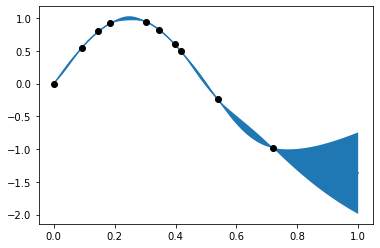

In [21]:
plot_prediction()

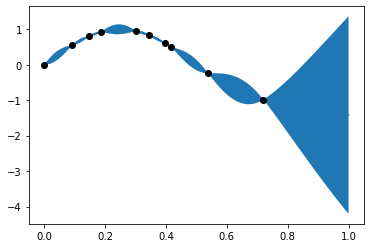

In [22]:
# You can change the kernel parameters to get different kinds of fits.
# Here, we are increasing the value of alpha0 from the default of 1.
plot_prediction(
    mean = lambda x : -0.5,
    kernel = lambda x1,x2 : matern(x1,x2, alpha0=20, length_scales=1.0, nu = 1.5))

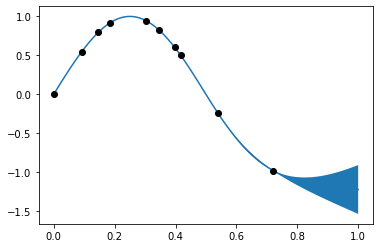

In [23]:
# Here is another cell for playing around with kernel parameters
plot_prediction(
    mean = lambda x : -2,
    kernel = lambda x1,x2 : matern(x1,x2, alpha0=1, length_scales=1.0, nu = 2.5))

#### Exercise 2

You can also use your code to simulate sample paths from a Gaussian process posterior with a
given mean and kernel function.  To do this, fill in the gaps in the following code.

In [ ]:
# CELL TO FILL IN FOR EXERCISE 2
def simulate_from_prior(mean=mean0, kernel=matern, m=20):
    x = np.linspace(0,1,m)
    y = np.zeros(m)
    
    # We will simulate from left to right (i=0 up to m-1),
    # storing the value of f(x[i]) in y[i].
    # For our first point (i=0), we will simulate from the prior, 
    # whose mean is the mean function evaluated at x[0],
    # and variance is the kernel function evaluated with both inputs at x[0].

    # FILL IN CODE TO COMPUTE y[0]    
    # Set y[0] to a normal random variable.
    # Its mean should be the mean function evaluated at x[0]
    # Its variance should be the kernel evaluated at x[0],x[0]
    # Use np.random.normal. Remember that it takes the standard devation as input, not the variance.
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    
    for i in range(m-1):
        # Get the posterior distribution at the point x[i+1] in our input space
        # given the observations we have simulated so far (x and y, 0 through i, inclusive).
        # This posterior distribution is normal. Use your predict function to get its 
        # mean and variance.
        
        # FILL IN CODE TO COMPUTE THE MEAN AND VARIANCE OF f(x[i+1])
        
        # Simulate a normal random variable with a mean and variance given by the posterior distribution
        # and plug it in to y[i+1]. You can use np.random.normal.
        
        # FILL IN CODE TO COMPUTE y[i+1]

    return (x,y)

#### Exercise 2 Solution

In [25]:
def simulate_from_prior(mean=mean0, kernel=matern, m=20):
    x = np.linspace(0,1,m)
    y = np.zeros(m)
    
    # We will simulate from left to right.  For our first point, we will 
    # simulate from the prior, whose mean can be computed from the mean function evaluated at x[0],
    # and variance can be computed from the kernel function evaluated with both inputs at x[0].
    y[0] = np.random.normal(mean(x[0]), np.sqrt(kernel(x[0],x[0])))
    
    for i in range(m-1):
        # Get the posterior distribution at the point x[i+1] in our input space
        # given the observations we have simulated so far (x and y, 0 through i, inclusive).
        m,v = predict(x[i+1],x[0:i+1],y[0:i+1],mean,kernel)
        
        # Simulate a normal random variable with a mean and variance given by the posterior distribution
        # and plug it in to y[i+1]
        y[i+1] = np.random.normal(m,np.sqrt(v))

    return (x,y)

#### End Exercise 2 Solution

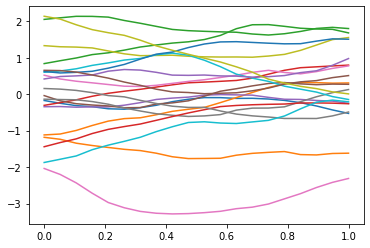

In [26]:
# Using this, we can simulate many different sample paths from the posterior
def simulate_many_from_prior(mean=mean0, kernel=matern, n=20, m=20):
    fig, ax = plt.subplots()
    for i in range(n):
        x,y = simulate_from_prior(mean,kernel,m)
        ax.plot(x,y)
        
simulate_many_from_prior()

#### Exercise 3

Play around with the parameters of the constant mean and matern kernel to understand how they
influence the predictions and the simulated sample paths.  In the following code, copied from above,
we see 3 parameters: the mean of the constant mean, and the alpha0, length_scales (which is a scalar when we 
have 1-dimensional x), and nu.

`plot_prediction(mean = lambda x : -0.5,
    kernel = lambda x1,x2 : matern(x1,x2, alpha0=20, length_scales=1.0, nu = 2))`
    
See if you can figure out parameters
that (approximately) reproduce the following pair of plots.  We set the value of nu to 1.5, since it is often hard to figure out what changes are due to nu vs. the length scale in this exercise.

To help you figure it out:
- The constant in the mean controls the average height of the simulated sample paths
- The alpha0 controls the overall spread of the simulated sample paths, which is easily visualized by looking at the range of values on the y-axis
- The length scale (and also nu) controls how wiggly each line is

In [ ]:
# CELL TO FILL IN FOR EXERCISE 3

# Fill in the 3 question marks to reproduce the two figures below
# You will want to copy this cell before you run it, to avoid losing the figures
# If you do lose the cell, you can download another copy of the notebook to reference
ex3_mean = lambda x : ?
ex3_kernel = lambda x1,x2 : matern(x1,x2, alpha0=?, length_scales=?, nu = 1.5)

plot_prediction(mean=ex3_mean, kernel = ex3_kernel)

#### Exercise 3 Solution

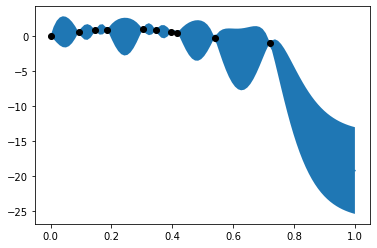

In [27]:
# Solution: mean = -20, alpha=10, length_scales=.1
ex3_mean = lambda x : -20
ex3_kernel = lambda x1,x2 : matern(x1,x2, alpha0=10.0, length_scales=.1, nu = 1.5)

plot_prediction(mean=ex3_mean, kernel = ex3_kernel)

#### End Exercise 3 Solution

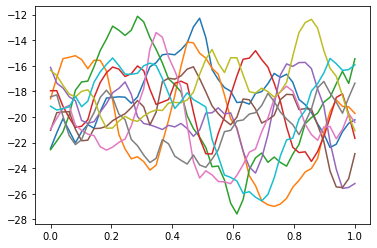

In [28]:
simulate_many_from_prior(ex3_mean, ex3_kernel, n=10, m=50)

In [29]:
# The following code makes a cross-validation plot
def leave_one_out(mean = mean0, kernel = matern):

    loo_mean = []
    loo_sdev = []

    for i in range(len(train_x)):
        loo_train_x = np.delete(train_x,i)
        loo_train_y = np.delete(train_y,i)
        ret = predict(train_x[i],loo_train_x,loo_train_y, mean = mean, kernel = kernel)
        loo_mean.append(ret[0])
        loo_sdev.append(np.sqrt(max(0.,ret[1])))
    
    fig, ax = plt.subplots()
    ax.errorbar(train_y,loo_mean,1.96*np.array(loo_sdev),fmt='o')
    ax.plot([min(train_y),max(train_y)],[min(train_y),max(train_y)],'k--')

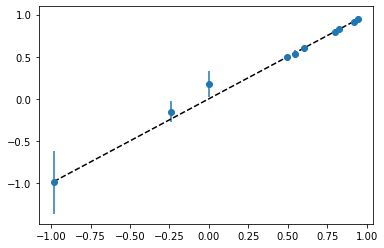

In [30]:
leave_one_out()

In [31]:
# Here is an implementation that supports optional homoscedastic gaussian noise
def predict_with_noise(test_x, train_x, train_y, mean = mean0, kernel=matern, noisevar=0.0):
    # Inputs:
    # test_x is a point in the x space
    # train_x is an array of points
    # train_y is an array equal in length to train_x, giving the value of our observation at each point
    # mean and kernel are two functions
    # mean should take one point as input, mean(x)
    # kernel should take two points as input, kernel(x,xprime)
    
    # Fill in your code here.
    # Solution
    mu0 = [mean(x) for x in train_x]

    # K is the matrix kernel(train_x,train_x)
    K = [[kernel(x1,x2) for x1 in train_x] for x2 in train_x]
    K += np.diag(noisevar*np.ones(len(train_x)))
    Kinv = np.linalg.inv(K)

    # A is the vector kernel(test_x,train_x), which is 1 by n
    # B is its product with K^-1
    A = np.array([kernel(test_x,x) for x in train_x])
    
    B = np.matmul(A,Kinv)

    pred_mean = np.matmul(B,np.transpose(np.array(train_y)-mu0)) + mean(test_x)
    pred_var = kernel(test_x,test_x) - np.matmul(B,np.transpose(A))
            
    return (pred_mean, pred_var)

print(predict(0.8, train_x, train_y))
print(predict_with_noise(0.8, train_x, train_y, noisevar=1.0))

(-1.1627288380229066, 0.007131362601578983)
(-0.035757966490506554, 0.29382617248589227)


In [32]:
# Testing for matern kernel
# Readers can ignore this cell on a first pass

import sklearn.gaussian_process.kernels

def test_matern1(test_dist = 1.0, test_nu=1.7):
    # Run a quick test on the Matern kernel.  Scikit learn has an implementation we can compare to
    skmatern = sklearn.gaussian_process.kernels.Matern(nu=test_nu)
    
    # Returns a 2x2 array where we care about the off-diagonal entries
    ret = skmatern([[0.0],[test_dist]])
    assert(np.isclose(matern(0.0,test_dist,nu=test_nu),ret[0][1]))

def test_matern2():
    #If we divide the input points by the length scale, and reset the length scale to 1,
    # the kernel value should be the same
    x0 = np.array([0.,0.])
    x1 = np.array([1.,1.])
    assert(np.isclose(matern(x0,x1,length_scales=2.),matern(x1,x1/2.,length_scales=1.)))
    assert(np.isclose(matern(x0,x1,length_scales=[2.,2.]),matern(x1,x1/2.,length_scales=1.)))

    
def test_matern3():
    # Had a problem with a distance of 0 returning nan
    assert(np.isclose(matern(0.0,0.0),1.))
    
test_matern1()
test_matern2()
test_matern3()